In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Part 1 - Exploratory Data Analysis

In [2]:
data = json.load(open('logins.json'))
logins_df = pd.DataFrame(data)
logins_df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


First step is to get the login data into a data frame so we can take a look at time intervals and how many people took rides at what times.

In [3]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df['count'] = 1
logins_df.set_index('login_time', inplace=True)

Starting with 15 minutes. We'll resample the data set to see how many people took a ride every 15 minutes. 

In [4]:
frequency_15_df = logins_df.resample('15T').sum()
frequency_15_df

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


Let's plot and see how the data looks.

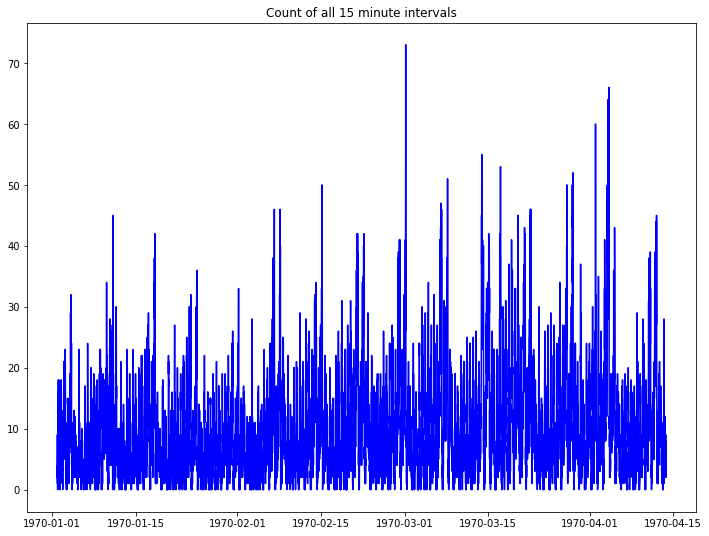

In [5]:
plt.figure(figsize=(12,9))
plt.plot(frequency_15_df['count'], color='blue')
plt.title('Count of all 15 minute intervals')
plt.show()

Really noisy. Tough to see any real patterns without broadening the scope of the data and generalizing it some more. Here you can see some peaks and valleys but it's tough to see any real trend in the data, so we'll take a look at the 1 day counts to see if that's better.

In [6]:
frequency_D_df = logins_df.resample('1D').sum()
frequency_D_df

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459
...,...
1970-04-09,818
1970-04-10,1009
1970-04-11,1352


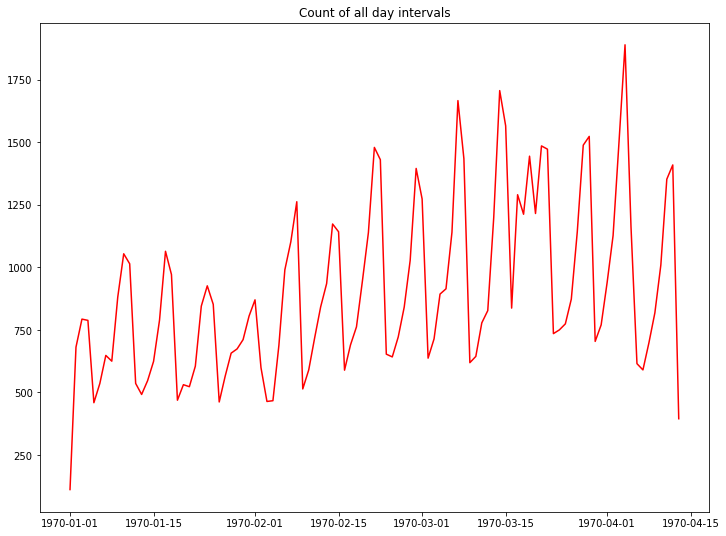

In [7]:
plt.figure(figsize=(12,9))
plt.plot(frequency_D_df['count'], color='red')
plt.title('Count of all day intervals')
plt.show()

Much better. The data is much less noisy and now we can see an overall trend. Seems like ride numbers are increasing as the year goes on. Could be due to people telling their friends about the service and more people are trying it. A good thing to potentially look into when we begin modeling.

For now though, let's get a bit more specific as well as more broad. We can see peaks and troughs that roughly correspond to days going by, so looking at peak hours during the day would be interesting. We can also get more broad by looking at peak days of the week, as well as looking at the overall trend as weeks and months go by.

In [8]:
logins_df['Hour'] = pd.DatetimeIndex(logins_df.index).hour
logins_df['Day of Week'] = pd.DatetimeIndex(logins_df.index).day_name()
logins_df['Week'] = pd.DatetimeIndex(logins_df.index).week
logins_df['Month'] = pd.DatetimeIndex(logins_df.index).month_name()
logins_df

,count,Hour,Day of Week,Week,Month
login_time,,,,,
1970-01-01 20:13:18,1,20,Thursday,1,January
1970-01-01 20:16:10,1,20,Thursday,1,January
1970-01-01 20:16:37,1,20,Thursday,1,January
1970-01-01 20:16:36,1,20,Thursday,1,January
1970-01-01 20:26:21,1,20,Thursday,1,January
...,...,...,...,...,...
1970-04-13 18:50:19,1,18,Monday,16,April
1970-04-13 18:43:56,1,18,Monday,16,April
1970-04-13 18:54:02,1,18,Monday,16,April


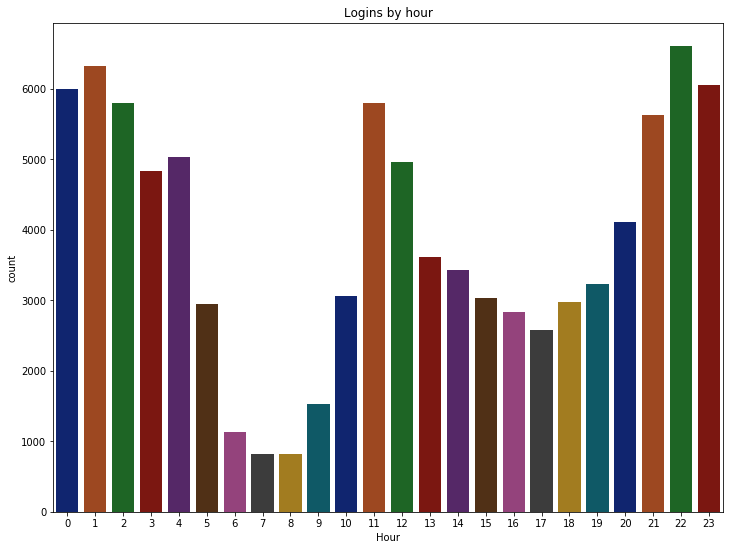

In [9]:
plt.figure(figsize=(12,9))
sns.countplot(logins_df['Hour'], palette='dark')
plt.title('Logins by hour')
plt.show()

Starting with hours. Seems like it correlates to the general work day. Peak hours seem to be at night while people are out and about, but taking a nose dive starting at about 5 am and bottoming out at 8 am when people are starting their work day. It picks up at around 11 am when lunch time starts, then falls back down until 5 pm when people are heading home. It's interesting that from 8 pm to 4 am there are such large counts. It seems like people are using this ride service all throughout the night.

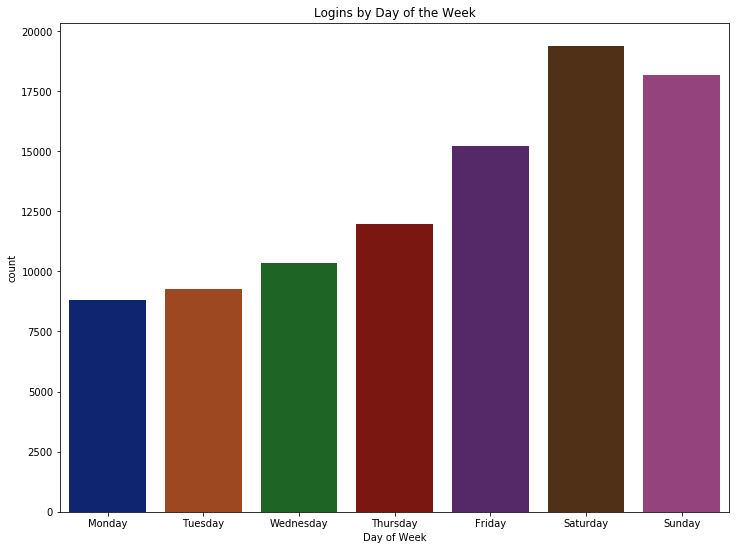

In [10]:
plt.figure(figsize=(12,9))
sns.countplot(logins_df['Day of Week'], palette='dark', order=['Monday', 'Tuesday', 'Wednesday', 
                                                            'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Logins by Day of the Week')
plt.show()

Seems like heavy use during the weekend. Which makes sense, people are more active and out and about during the weekend, so this ride service will see the most business during the weekends.

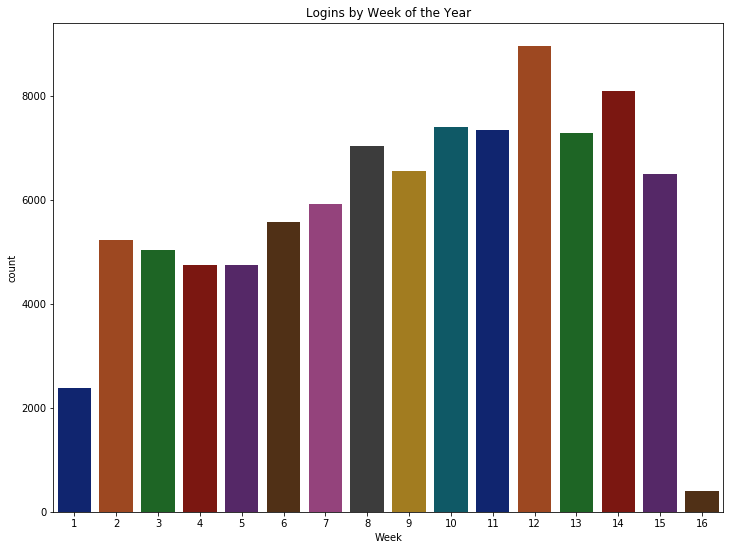

In [11]:
plt.figure(figsize=(12,9))
sns.countplot(logins_df['Week'], palette='dark')
plt.title('Logins by Week of the Year')
plt.show()

Here we can start seeing the overall trend of the data set. As time goes on, it seems that more people are using the service, which is good for business.

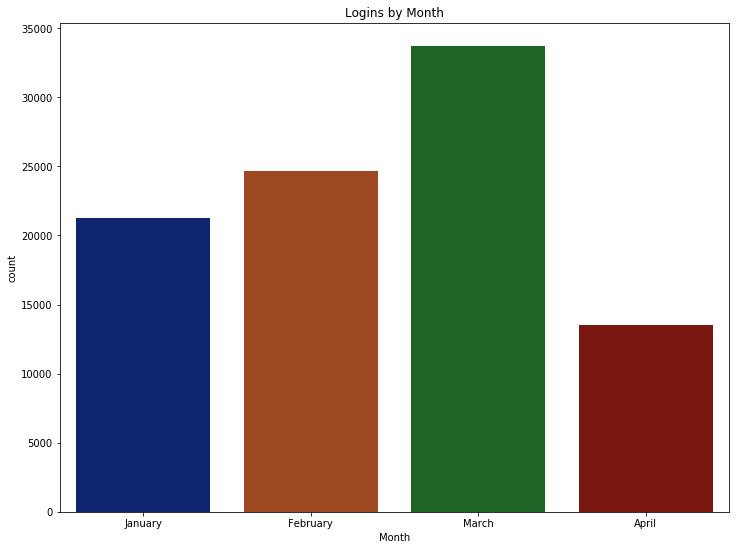

In [12]:
plt.figure(figsize=(12,9))
sns.countplot(logins_df['Month'], palette='dark')
plt.title('Logins by Month')
plt.show()

And here's a more general view of the trend, going by month instead of week. We don't have all of April's data, so more data will need to be taken and inserted into the data set to see how the entire month of April did compared to the first three months.

# Part 2 - Experiment and metrics design

**1)** The key measure of success here I think would be the total number of engagements of drivers in both cities. Reimbursing the toll was a good incentive for that, and this will allow the Ultimate managers to get a solid understanding on if the toll reimbursement had the desired effect of more drivers working in both cities.

**2)** Before we get into any experiments, we would need data on how many drivers already cross into the other city and for how long they stay there or how often they go back and forth. This would serve as our control data. After all the data we need is collected, announce the toll reimbursement policy and start tracking driver movement again. We would then compare the two data sets by using a t-test to determine if the average number of driver crossings is statistically signficant. From there, performing a cost/benefit analysis on revenue generated by the new policy vs. the cost from giving all that money back would be needed to determine if the toll reimbursement policy is to be kept in place.

# Part 3 - Predictive modeling

In [13]:
data = json.load(open('ultimate_data_challenge.json'))
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


It seems like we have some missing data, let's see if we can fill that. First let's start off with phone column. We have 396 missing data points, let's take a look at them.

In [16]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

The vast majority of users are using iPhones, so it would be safe to assume the other 396 people that we don't have data on are using iPhones, and we can fill in the column.

In [17]:
df['phone'] = df['phone'].fillna('iPhone')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Done. Now let's take a look at the avg_rating_by_driver column since there are only 201 missing data points there

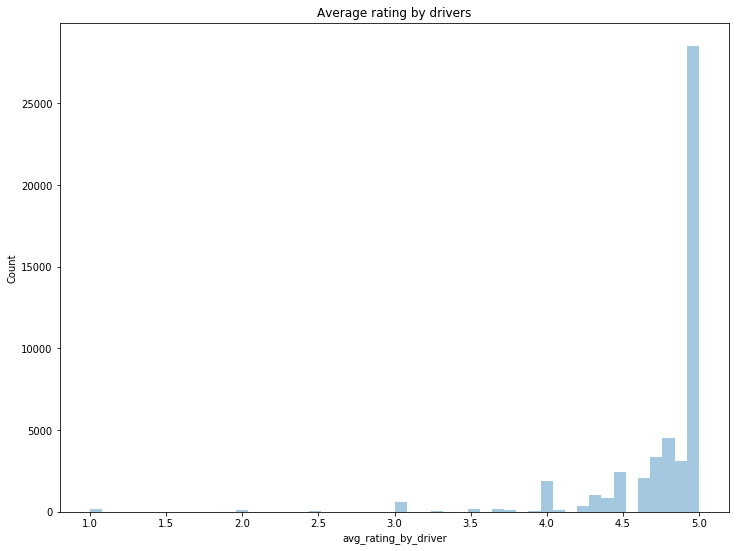

In [18]:
plt.figure(figsize=(12,9))
sns.distplot(df[df['avg_rating_by_driver'].notnull()]['avg_rating_by_driver'], hist=True, kde=False)
plt.ylabel('Count')
plt.title('Average rating by drivers')
plt.show()

Seems like the majority of the ratings are greater than 4.5. Let's take a look at some of the stats of the column.

In [19]:
df['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [20]:
df['avg_rating_by_driver'].value_counts()

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

Since the vast majority of ratings here are 5 stars, we'll fill in the rest of the missing data with that. It shouldn't make too much of a difference in the long run, as a 5 star rating has more than 6 times more ratings than the 2nd largets group.

In [21]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].max())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Now that we got that column figured out, let's take a look at the last non-full column, avg_rating_of_driver

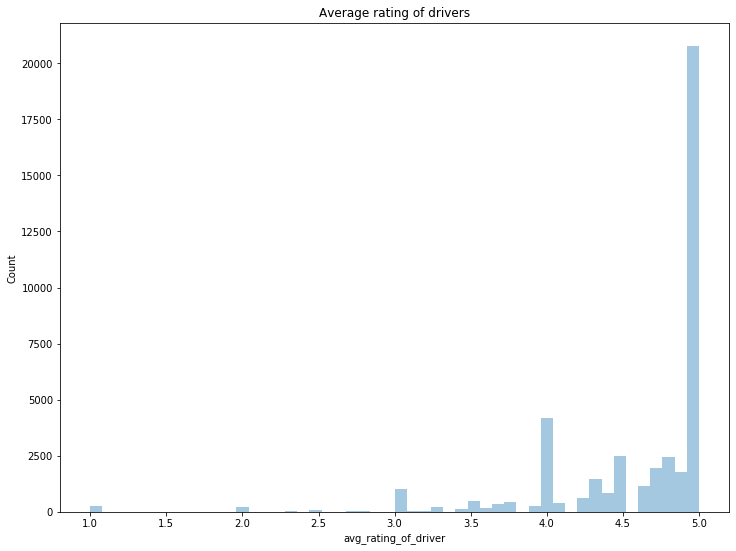

In [22]:
plt.figure(figsize=(12,9))
sns.distplot(df[df['avg_rating_of_driver'].notnull()]['avg_rating_of_driver'], hist=True, kde=False)
plt.ylabel('Count')
plt.title('Average rating of drivers')
plt.show()

In [23]:
df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [24]:
df['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

this column is a little less straightforward. The distribution isn't as skewed as the other column, and the 50th percentile (median) isn't at the max. From this, instead of filling by the max, we should fill by random numbers between 4.5 and 5.0. Since there are close to 8000 missing values in this column, I think it could potentially skew any future modeling that we would want to do. Filling it with random numbers between those values (most of the common values) would give a more balanced fill and wouldn't skew the data nearly as much.

In [25]:
np.arange(4.5, 5.1, .1)

array([4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [26]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].apply(lambda x: np.random.choice([x for x in np.arange(4.5, 5.1, .1)]) if (np.isnan(x)) else x)

In [27]:
df['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     3858
4.6     2495
4.8     2430
4.7     1945
4.9     1771
4.3     1487
5.0     1366
4.8     1366
4.7     1343
4.9     1335
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
2.2        1
1.9        1
1.6        1
Name: avg_rating_of_driver, dtype: int64

In [28]:
df['avg_rating_of_driver'].describe()

count    50000.000000
mean         4.625674
std          0.571795
min          1.000000
25%          4.500000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Now all of our data is filled and not missing any values. Now we need to create our target variable. We need to find out what users were active in the 30 days before the very last trip was taken.

In [30]:
print('Last trip:', max(pd.to_datetime(df['last_trip_date'])))

Last trip: 2014-07-01 00:00:00


First let's make sure that these columns are datetime columns and not anything else.

In [31]:
df['signup_date'] = df['signup_date'].apply(lambda x: pd.Timestamp(x))

df['last_trip_date'] = df['last_trip_date'].apply(lambda x: pd.Timestamp(x))

In [32]:
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

In [33]:
df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

Now that we have our retained information, let's start modeling. This is a binary classification problem, so I think Gradient Boosting Classifier would be a good way to go here as that's a reliable model that produces good results. We can get some dummy variables to get more information out of our column for use when looking at feature importances.

Using GridSearchCV and the cross validation that comes along with it is a good way to accurately tune hyperparameters for the model and will give us the most accurate classifier we can get.

In [34]:
df = pd.get_dummies(df, prefix='is')

X = df.drop(['retained'], axis=1).select_dtypes(exclude='datetime64[ns]')
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)

steps = [('gboost', GradientBoostingClassifier(verbose=True, random_state=11))]
param_grid = {'gboost__n_estimators': np.arange(100, 600, 100),
              'gboost__max_depth': np.arange(5, 20, 5)}

pipeline = Pipeline(steps)
cv = GridSearchCV(pipeline, param_grid, cv=3)
cv.fit(X_train, y_train);

      Iter       Train Loss   Remaining Time 
         1           1.2698            3.67s
         2           1.2250            3.58s
         3           1.1877            3.55s
         4           1.1551            3.52s
         5           1.1271            3.49s
         6           1.1007            3.46s
         7           1.0790            3.41s
         8           1.0603            3.36s
         9           1.0413            3.33s
        10           1.0272            3.29s
        20           0.9425            2.93s
        30           0.9090            2.55s
        40           0.8905            2.18s
        50           0.8768            1.83s
        60           0.8667            1.46s
        70           0.8570            1.10s
        80           0.8488            0.73s
        90           0.8418            0.37s
       100           0.8356            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2702            3.67s
        

        60           0.8606            8.69s
        70           0.8510            8.31s
        80           0.8410            7.95s
        90           0.8333            7.58s
       100           0.8260            7.24s
       200           0.7731            3.61s
       300           0.7269            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2698           14.37s
         2           1.2250           14.34s
         3           1.1877           14.44s
         4           1.1551           14.37s
         5           1.1271           14.47s
         6           1.1007           14.40s
         7           1.0790           14.33s
         8           1.0603           14.23s
         9           1.0413           14.22s
        10           1.0272           14.17s
        20           0.9425           13.89s
        30           0.9090           13.47s
        40           0.8905           13.10s
        50           0.8768           12.79s
        6

        50           0.5307            5.34s
        60           0.4932            4.22s
        70           0.4613            3.14s
        80           0.4308            2.08s
        90           0.4059            1.04s
       100           0.3826            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2396           10.40s
         2           1.1699           10.45s
         3           1.1120           10.45s
         4           1.0627           10.35s
         5           1.0205           10.25s
         6           0.9834           10.18s
         7           0.9517           10.12s
         8           0.9212           10.07s
         9           0.8946           10.03s
        10           0.8708            9.95s
        20           0.7104            9.05s
        30           0.6246            7.91s
        40           0.5649            6.66s
        50           0.5203            5.46s
        60           0.4858            4.38s
        7

         4           1.0703           49.22s
         5           1.0297           49.69s
         6           0.9930           50.12s
         7           0.9612           50.53s
         8           0.9325           50.48s
         9           0.9050           50.88s
        10           0.8812           51.11s
        20           0.7229           50.26s
        30           0.6293           48.30s
        40           0.5727           46.22s
        50           0.5307           44.67s
        60           0.4932           43.24s
        70           0.4613           41.77s
        80           0.4308           40.43s
        90           0.4059           39.04s
       100           0.3826           37.66s
       200           0.2296           24.47s
       300           0.1356           12.16s
       400           0.0825            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2396           49.33s
         2           1.1699           49.27s
         

         8           0.6771            1.17m
         9           0.6322            1.18m
        10           0.5932            1.18m
        20           0.3413            1.23m
        30           0.2209            1.20m
        40           0.1573            1.15m
        50           0.1192            1.07m
        60           0.0936           58.47s
        70           0.0784           52.38s
        80           0.0643           47.46s
        90           0.0550           42.40s
       100           0.0468           37.85s
       200           0.0138            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1886            1.10m
         2           1.0784            1.09m
         3           0.9857            1.11m
         4           0.9074            1.11m
         5           0.8376            1.14m
         6           0.7758            1.16m
         7           0.7214            1.17m
         8           0.6730            1.18m
         

        60           0.1026            2.34m
        70           0.0844            2.17m
        80           0.0692            2.04m
        90           0.0570            1.92m
       100           0.0491            1.80m
       200           0.0154           59.19s
       300           0.0076           26.33s
       400           0.0057            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1912            2.28m
         2           1.0821            2.31m
         3           0.9905            2.36m
         4           0.9098            2.42m
         5           0.8416            2.46m
         6           0.7812            2.51m
         7           0.7262            2.55m
         8           0.6771            2.61m
         9           0.6322            2.64m
        10           0.5932            2.66m
        20           0.3413            2.85m
        30           0.2209            2.94m
        40           0.1573            2.92m
        5

In [35]:
print(f'Gradient Boosting Best Parameters: {cv.best_params_}')
print(f'Training Score from best tuned model: {round(cv.best_score_*100, 2)}%')

Gradient Boosting Best Parameters: {'gboost__max_depth': 5, 'gboost__n_estimators': 200}
Training Score from best tuned model: 78.76%


78.9% accuracy on the training set, that's not too bad. Let's make a prediction on unseen data using our best parameters and see how we do there.

In [36]:
y_pred = cv.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {round(test_score*100, 2)}%')

Model accuracy: 78.68%


Very similar, 78.7% accuracy. No signs of overfitting too which is good. However accuracy isn't the best metric for classifiers. Let's take a look at the classification report that this model gave us and see how accurately it predicted each class.

In [37]:
print('Gradient Boosting Classification Report')
print(classification_report(y_test, y_pred))

Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7799
           1       0.75      0.65      0.70      4701

    accuracy                           0.79     12500
   macro avg       0.78      0.76      0.77     12500
weighted avg       0.78      0.79      0.78     12500



Did well on class 0 but not great on class 1. Though that was to be expected with this being an unbalanced data set. Fortunately we had less than twice the amount of 0 classes as we did 1 classes, so this model wasn't overwhelmed with one class. But the thing we're looking for most is the feature importances. These will really tell us what Ultimate should focus on to keep riders

In [38]:
pipeline.fit(X_test, y_test);

importance = pipeline.named_steps['gboost'].feature_importances_

feature_importance = list(zip(X_test.columns, importance))
feature_importances = pd.DataFrame.from_records(feature_importance, columns=['Feature', 'Importance'])
feature_importances = feature_importances.set_index('Feature').sort_values('Importance', ascending=True)
feature_importances

      Iter       Train Loss   Remaining Time 
         1           1.2804            1.28s
         2           1.2447            1.35s
         3           1.2135            1.43s
         4           1.1875            1.43s
         5           1.1651            1.40s
         6           1.1458            1.39s
         7           1.1286            1.37s
         8           1.1067            1.35s
         9           1.0930            1.34s
        10           1.0757            1.33s
        20           0.9921            1.18s
        30           0.9582            1.04s
        40           0.9395            0.89s
        50           0.9280            0.74s
        60           0.9196            0.59s
        70           0.9127            0.44s
        80           0.9067            0.29s
        90           0.9008            0.15s
       100           0.8971            0.00s


,Importance
Feature,
is_Winterfell,0.000000
avg_surge,0.009833
avg_rating_of_driver,0.010353
avg_dist,0.026266
is_Astapor,0.026694
is_iPhone,0.031423
trips_in_first_30_days,0.045994
ultimate_black_user,0.061261
is_Android,0.062564


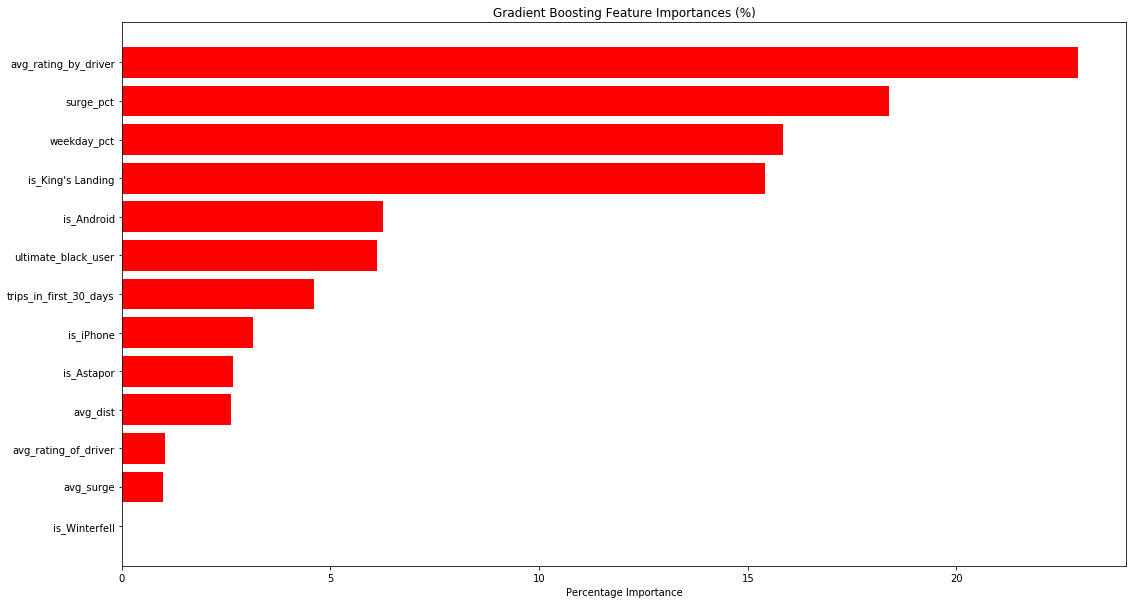

In [39]:
plt.figure(figsize=(18,10))
plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
plt.title("Gradient Boosting Feature Importances (%)")
plt.xlabel('Percentage Importance')
plt.show()

Average rating by the driver is the most important feature for keeping riders around into their 6th month on the app. People who are happy with their rating are more likely to stick around, which makes sense. People taking trips during the weekdays also seem fairly important in keeping riders around for future trips. Seems like if they like the service taking them to or from work, they're more likely to stick around. Someone being an Ultimate Black user being about halfway down was surprising. One would think as people are paying extra for the service, they would be more likely to use that service more, but apparently there are other factors that play a more important role.

## Conclusion

Ultimate could take a few things away from this model's insight. First off give more incentive to Ultimate Black users to get them to take advantage of the service more. This could be providing discounts on rides, coming up with a rewards system after X number of rides, or any number of other ideas Ultimate could come up with. Also finiding ways to incentivise weekday trips and keeping surge percentages up. These are both very important to the rider retention model, and coming up with a marketing strategy focused on these and finding ways to incentivise them would be a good way to keep riders around.